# Model training and predictions 
### Read from file and data cleaning

In [1]:
# File location and type
file_location = "sample_comb3.csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
multiline = "true"
escape = "\""

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.csv(file_location,
                  inferSchema = infer_schema, 
                  sep = delimiter, 
                  header = first_row_is_header, 
                  multiLine = multiline, 
                  escape = escape)

In [2]:
df.rdd.getNumPartitions()

1

In [3]:
df = df.repartition(8)

In [4]:
df.show()

+--------------------+--------------------+---------------+
|                Body|               Title|            tag|
+--------------------+--------------------+---------------+
|<p>Experiencing d...|Boost.log V1 Comp...|          boost|
|<p>I've posted si...|NSFetchRequest me...|            ios|
|<p>I've been cons...|Fundamental Drag ...|  drag-and-drop|
|<p>I have a jQuer...|Echo PHP variable...|         jquery|
|<p>I have a model...|Transparently sto...|            mvc|
|<p>Firstly, no OA...|How to implement ...|          login|
|<p>I have my mod_...|mod_rewrite brows...|    mod-rewrite|
|<p>I am having tr...|How to bind the v...|           xaml|
|<p>I am using the...|cursor jumps to s...|           ipad|
|<p>I am new to th...|Single Database a...|   web-services|
|<p>I'm using the ...|UITableview datas...|    cocoa-touch|
|<pre><code>&lt;?x...|How to build .air...|            air|
|<p>There is a Sel...|Query Notation fo...|         select|
|<p>I'm new to Jav...|Simple Javascript.

### Indexing tags in both test and train data sets

In [5]:
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer

tag_idx = StringIndexer(inputCol='tag', outputCol = 'tag_idx')
tag_encode = tag_idx.fit(df)
df = tag_encode.transform(df)

In [6]:
df.count()

99785

In [7]:
df.show()

+--------------------+--------------------+---------------+-------+
|                Body|               Title|            tag|tag_idx|
+--------------------+--------------------+---------------+-------+
|<p>Experiencing d...|Boost.log V1 Comp...|          boost|  212.0|
|<p>I've posted si...|NSFetchRequest me...|            ios|    1.0|
|<p>I've been cons...|Fundamental Drag ...|  drag-and-drop|  331.0|
|<p>I have a jQuer...|Echo PHP variable...|         jquery|    9.0|
|<p>I have a model...|Transparently sto...|            mvc|  151.0|
|<p>Firstly, no OA...|How to implement ...|          login|  141.0|
|<p>I have my mod_...|mod_rewrite brows...|    mod-rewrite|   79.0|
|<p>I am having tr...|How to bind the v...|           xaml|   36.0|
|<p>I am using the...|cursor jumps to s...|           ipad|   12.0|
|<p>I am new to th...|Single Database a...|   web-services|   27.0|
|<p>I'm using the ...|UITableview datas...|    cocoa-touch|   10.0|
|<pre><code>&lt;?x...|How to build .air...|     

### Preprocessing

In [8]:
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import RegexTokenizer

""" Helper functions for preprocessing. 
"""

@udf("String")
def lazy_prep_udf(c):
  """
  Clean noises from the string of text in given column

  Args:
    c - Column containing string of text

  Returns:
    Column with the cleaned string of text
  """
  df = BeautifulSoup(c)
  
  #noise
  urls = df.find_all('a')
  if urls != None:
    if len(urls)>0: 
      df.a.clear()
  
  return df.get_text().lower()


def tokenize(df, inputCol, outputCol):
  """
Split string of text in dataframe to word tokens.

Args:
  @param df Dataframe containing string of text
  @param inputCol name of input column containin the string of texts
  @param outputCol name of output column containin the word tokens
  
Returns:
  Dataframe containing the output column and the input column is dropped
"""
  tokenizer = RegexTokenizer(inputCol = inputCol, outputCol = outputCol, pattern=r"\s+") 
  df = tokenizer.transform(df).drop(inputCol)
  return df


def remove_punc(text):
  """Removes all punctuation marks from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String.sql.Row: text w.o punctuation 
  """
  mod_punc = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~'
  text = text.translate(str.maketrans(' ', ' ', mod_punc))
  return text.strip()


def remove_num(text):
  """Removes all numbers from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String: text w.o numbers 
  """
  numbers="0123456789"
  text = text.translate(str.maketrans(' ', ' ', numbers))
  return text.strip()


from nltk.tokenize import RegexpTokenizer 

@udf("String")
def trad_prep_udf(body):
  """Traditional body text preprocessing pieline. 
  Args: 
    text (pyspark.sql.Row): Text String to process
  Returns: 
    pyspark.sql.Row.ArrayType: cleaned tokens 
  """
  body = BeautifulSoup(body)
  stemmer = PorterStemmer()
  
  #noise
  urls = body.find_all('a')
  if len(urls)>0: 
    body.a.clear()
  
  text = body.get_text()
  
  words = []
  text = text.lower()

  tokenizer = RegexpTokenizer(r'\w+')
#   text = remove_punc(text)
#   text = remove_num(text)
  sents=tokenizer.tokenize(text)
  for sent in sents: 
    for word in nltk.word_tokenize(sent):
      if word in stop_en: continue
      words.append(stemmer.stem(word))
  return " ".join(words)


  """
Combine word tokens from title and body.

Args:
  df1 Dataframe containing Column with lists of stemmed word tokens from title
  inputCol1 name of the column containing lists of stemmed word tokens from title, cannot be same as inputCol2
  df2 Dataframe containing Column with lists of stemmed word tokens from body
  inputCol2 name of the column containing lists of stemmed word tokens from body, cannot be same as inputCol2
  outputCol column name of the ouput column containing the combined list of word tokens from title and body
"""
def combine_tokens(df, inputCol1, inputCol2, outputCol):
  result = df.withColumn(outputCol, concat(col(inputCol1), col(inputCol2)))
  return result

[nltk_data] Downloading package punkt to /Users/tongxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tongxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
class Preprocessing:
  """Preprocessing stackoverflow question by remove html tags and tokenize words"""
  
  def __init__(self, df, titleCol, bodyCol):
    """
    Construct a Proprocessing object with attribute df: df cleans the text string in the given df using either lazy or traditional preprocessing
    """
#     df = df.withColumn("Lazy_Title", lazy_prep_udf( df[titleCol] ) )
#     df = df.withColumn("Lazy_Body", lazy_prep_udf( df[bodyCol] ) )
    df = df.withColumn("Trad_Title", trad_prep_udf( df[titleCol] ) )
    self.df = df.withColumn("Trad_Body", trad_prep_udf( df[bodyCol] ) )

  def get_token(self):
#     self.df = tokenize(self.df, "Lazy_Title", 'Lazy_Title_Tokens')
#     self.df = tokenize(self.df, "Lazy_Body", 'Lazy_Body_Tokens')
    self.df = tokenize(self.df, "Trad_Title", 'Trad_Title_Tokens')
    self.df = tokenize(self.df, "Trad_Body", 'Trad_Body_Tokens')
    return self.df

In [10]:
#Pre-processing the data
preProcessing = Preprocessing(df, "Title", "Body")
df_data = preProcessing.get_token()
display(df_data.toPandas())

,Body,Title,tag,tag_idx,Trad_Title_Tokens,Trad_Body_Tokens
0,<p>Experiencing difficulty in compiling boost....,Boost.log V1 Compilation Error,boost,212.0,"[boost, log, v1, compil, error]","[experienc, difficulti, compil, boost, log, v1..."
1,<p>I've posted similar questions about differe...,NSFetchRequest memory problems,ios,1.0,"[nsfetchrequest, memori, problem]","[post, similar, question, differ, thing, relat..."
2,<p>I've been considering an app now that imple...,Fundamental Drag And Drop In iOS,drag-and-drop,331.0,"[fundament, drag, drop, io]","[consid, app, implement, drag, drop, sort, idi..."
3,<p>I have a jQuery script that I am including ...,Echo PHP variable inside jQuery SwitchCase?,jquery,9.0,"[echo, php, variabl, insid, jqueri, switchcas]","[jqueri, script, includ, php, page, take, mt, ..."
4,<p>I have a model (MVC) class whose internal s...,Transparently storing class state without expo...,mvc,151.0,"[transpar, store, class, state, without, expos...","[model, mvc, class, whose, intern, state, basi..."
...,...,...,...,...,...,...
99780,<p>I'm very new to MySQL and I have a stored p...,MySQL: Loop through databases and run a stored...,loops,68.0,"[mysql, loop, databas, run, store, procedur]","[new, mysql, store, procedur, like, add, sever..."
99781,<p>How to check or validate the textbox entere...,How to check or validate the textbox entered d...,datetime,107.0,"[check, valid, textbox, enter, date, dd, mm, y...","[check, valid, textbox, enter, date, dd, mm, y..."
99782,<p>I am designing a template class Policy whic...,C++ Class inheriting from template class witho...,templates,154.0,"[c, class, inherit, templat, class, without, k...","[design, templat, class, polici, need, abl, ha..."
99783,"<p>I use a script generator -- <a href=""http:/...",Easiest way in browser to detect mobile phones,mobile,120.0,"[easiest, way, browser, detect, mobil, phone]","[use, script, gener, detect, mobil, phone, ord..."


In [3]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(desc('count'))
tag_counts.show()

+---------------+-----+
|            tag|count|
+---------------+-----+
|           html| 1869|
|            ios| 1291|
|           ajax| 1287|
|            css| 1261|
|          xcode|  955|
|       database|  791|
|           json|  769|
|          query|  683|
|        asp.net|  655|
|         jquery|  647|
|    cocoa-touch|  622|
|          forms|  615|
|           ipad|  600|
|ruby-on-rails-3|  588|
|            sql|  587|
|         string|  571|
|          html5|  535|
|       winforms|  527|
|            xml|  523|
|    performance|  511|
+---------------+-----+
only showing top 20 rows



In [4]:
from pyspark.sql.functions import col

tag_counts = df.select('tag').groupby('tag').count().sort(col('count'))
tag_counts.show()

+---------------+-----+
|            tag|count|
+---------------+-----+
|          scope|   71|
|     javascript|   76|
|          click|   77|
|            usb|   78|
|           jaxb|   78|
|            get|   80|
|     sharepoint|   80|
|           find|   80|
|         scroll|   81|
|          jsf-2|   81|
|       treeview|   83|
|        include|   84|
|      amazon-s3|   84|
|          popup|   84|
|           cron|   85|
|silverlight-4.0|   85|
|       iterator|   85|
| floating-point|   86|
|   coding-style|   86|
|          uikit|   87|
+---------------+-----+
only showing top 20 rows



In [21]:
body_counts = df_data.select('Trad_Body_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Body_Tokens]).reduceByKey(lambda a,b: a+b).collect()
body_counts.sort(key=lambda tup: -tup[1])

display(body_counts)

[('0', 103385),
 ('use', 100527),
 ('1', 96740),
 ('new', 62197),
 ('class', 60289),
 ('get', 59327),
 ('id', 59191),
 ('name', 58157),
 ('file', 56129),
 ('code', 53455),
 ('valu', 53129),
 ('2', 52726),
 ('string', 51795),
 ('data', 50050),
 ('like', 48286),
 ('function', 48281),
 ('work', 48087),
 ('tri', 46788),
 ('user', 44170),
 ('public', 41432),
 ('return', 40423),
 ('type', 39988),
 ('want', 39741),
 ('java', 38610),
 ('text', 38210),
 ('error', 37978),
 ('div', 35240),
 ('would', 35212),
 ('set', 34329),
 ('need', 32416),
 ('3', 32332),
 ('c', 32175),
 ('creat', 31922),
 ('int', 31156),
 ('page', 30864),
 ('one', 30353),
 ('php', 30202),
 ('object', 30114),
 ('server', 29991),
 ('tabl', 29575),
 ('select', 29160),
 ('way', 29073),
 ('http', 28112),
 ('var', 27488),
 ('com', 27390),
 ('system', 27266),
 ('imag', 27010),
 ('problem', 26943),
 ('applic', 26672),
 ('android', 26636),
 ('e', 26424),
 ('method', 26208),
 ('thank', 26123),
 ('html', 25366),
 ('call', 24955),
 ('view

In [22]:
title_counts = df_data.select('Trad_Title_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Title_Tokens]).reduceByKey(lambda a,b: a+b).collect()
title_counts.sort(key=lambda tup: -tup[1])

display(title_counts)

[('use', 10164),
 ('c', 5743),
 ('file', 5742),
 ('jqueri', 5009),
 ('get', 4432),
 ('php', 4343),
 ('data', 3926),
 ('net', 3891),
 ('object', 3268),
 ('work', 3227),
 ('valu', 3216),
 ('error', 3189),
 ('java', 3121),
 ('sql', 3048),
 ('server', 3039),
 ('javascript', 3019),
 ('window', 2931),
 ('android', 2858),
 ('imag', 2839),
 ('array', 2667),
 ('string', 2628),
 ('creat', 2613),
 ('tabl', 2612),
 ('function', 2512),
 ('page', 2501),
 ('applic', 2474),
 ('databas', 2452),
 ('mysql', 2443),
 ('asp', 2431),
 ('class', 2429),
 ('app', 2400),
 ('queri', 2204),
 ('form', 2176),
 ('chang', 2144),
 ('web', 2074),
 ('set', 2054),
 ('list', 2047),
 ('multipl', 2044),
 ('html', 2037),
 ('select', 2026),
 ('call', 1952),
 ('view', 1914),
 ('code', 1905),
 ('method', 1900),
 ('control', 1895),
 ('ajax', 1881),
 ('load', 1870),
 ('way', 1863),
 ('user', 1834),
 ('text', 1832),
 ('xml', 1767),
 ('one', 1755),
 ('return', 1664),
 ('access', 1650),
 ('iphon', 1644),
 ('differ', 1643),
 ('make', 

### Split test/train sets

In [8]:
TRAINING_DATA_RATIO = 0.9
RANDOM_SEED = 1234

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = df.randomSplit(splits, RANDOM_SEED)

In [9]:
print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

Number of training set rows: 89882
Number of test set rows: 9903


In [12]:
#Pre-processing the data
preProcessing = Preprocessing(test_data, "Title", "Body")
test_data = preProcessing.get_token()
preProcessing = Preprocessing(training_data, "Title", "Body")
training_data = preProcessing.get_token()


# Machine Learning Data Preparation

### Feature Engineering

In [13]:
from pyspark.ml.feature import CountVectorizer, IDF, NGram, VectorAssembler, StringIndexer, HashingTF
from pyspark.ml import Pipeline
def feature_engineer():
# # FOR LAZY PRE-PROCESSING
#   lazy_body_vector = CountVectorizer(inputCol = 'Lazy_Body_Tokens', outputCol = 'lazy_body_vector', minDF=0.01 , maxDF=0.85)
#   lazy_title_vector = CountVectorizer(inputCol = 'Lazy_Title_Tokens', outputCol = 'lazy_title_vector', minDF=0.01 , maxDF=0.85)
  
    # FOR TRAD PRE-PROCESSING
    trad_body_vector = CountVectorizer(inputCol = 'Trad_Body_Tokens', outputCol = 'trad_body_vector', minDF=0.01 , maxDF=0.99)
    trad_title_vector = CountVectorizer(inputCol = 'Trad_Title_Tokens', outputCol = 'trad_title_vector', minDF=0.01 , maxDF=0.99)

#   lazy_body_idf = IDF(inputCol='lazy_body_vector', outputCol='lazy_body_idf')
#   lazy_title_idf = IDF(inputCol='lazy_title_vector', outputCol='lazy_title_idf')

#   trad_body_idf = IDF(inputCol='trad_body_vector', outputCol='trad_body_idf')
#   trad_title_idf = IDF(inputCol='trad_body_vector', outputCol='trad_title_idf')

#   lazy_features = VectorAssembler(inputCols=['lazy_body_vector', 'lazy_title_vector'], outputCol='lazy_features')
    trad_features = VectorAssembler(inputCols=['trad_body_vector', 'trad_title_vector'], outputCol='trad_features')
    
#     pipe = Pipeline(stages=[lazy_body_vector, lazy_title_vector, lazy_features, trad_body_vector, trad_title_vector, trad_features])
    pipe = Pipeline(stages=[trad_body_vector, trad_title_vector, trad_features])
    
    pipe_model = pipe.fit(training_data)
    train_df = pipe_model.transform(training_data)  
    test_df = pipe_model.transform(test_data)
    return train_df, test_df

In [16]:
train_df, test_df = feature_engineer()
display(test_df.toPandas())

,Body,Title,tag,tag_idx,Trad_Title_Tokens,Trad_Body_Tokens,trad_body_vector,trad_title_vector,trad_features
0,<blockquote>\n <p><strong>Possible Duplicate:...,Query about expiry of access token,facebook-graph-api,105.0,"[queri, expiri, access, token]","[possibl, duplic, right, know, access, token, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,<blockquote>\n <p><strong>Possible Duplicate:...,How to know if the output is going to a termin...,linux,135.0,"[know, output, go, termin]","[possibl, duplic, want, know, output, program,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ..."
2,<blockquote>\n <p><strong>Possible Duplicate:...,CXXFLAGS modification From My .pro File,qt,228.0,"[cxxflag, modif, pro, file]","[possibl, duplic, hello, would, like, use, o1,...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ..."
3,<blockquote>\n <p><strong>Possible Duplicate:...,Ensure a process ends with my application in C...,thread-safety,473.0,"[ensur, process, end, applic, c, sharp]","[possibl, duplic, use, system, diagnost, proce...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,<blockquote>\n <p><strong>Possible Duplicate:...,Primefaces Login Application,java-ee,70.0,"[primefac, login, applic]","[possibl, duplic, use, primefac, implement, we...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
9898,<pre><code>bmpAndroidMarker = BitmapFactory.de...,Android bitmap rotate canvas crops/cuts image,rotation,433.0,"[android, bitmap, rotat, canva, crop, cut, imag]","[bmpandroidmark, bitmapfactori, decoderesourc,...","(2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9899,<pre><code>case R.id.btn7:\n if (mp != null...,App with media Player forces down,homework,248.0,"[app, media, player, forc]","[case, r, id, btn7, mp, null, mp, isplay, mp, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, ..."
9900,"<pre><code>document.getElementById(""elementId""...","JavaScript style.display=""none"" or jQuery .hid...",css,3.0,"[javascript, style, display, none, jqueri, hid...","[document, getelementbyid, elementid, style, d...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9901,<pre><code>import java.io.IOException;\nimport...,error in create pie chart in jsp using jfree,servlets,73.0,"[error, creat, pie, chart, jsp, use, jfree]","[import, java, io, ioexcept, import, javax, se...","(0.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, ..."


In [21]:
test_df.write.parquet("test_df_comb")
train_df.write.parquet("train_df_comb")

# Model Training

## Logistic Regression

**Hyperparameter Tuning**

In [1]:
test_df = spark.read.parquet("test_df_comb")
test_df = test_df.repartition(8)
train_df = spark.read.parquet("train_df_comb")
train_df = train_df.repartition(8) 

In [2]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString


lr = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0, 0.01, 0.1, 1.0]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_tvs = TrainValidationSplit(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9, 
                          seed=0
                         )



In [3]:
model = lr_tvs.fit(train_df)

In [4]:
print('Best Param (regParam): ', model.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', model.bestModel._java_obj.getElasticNetParam())
print('Best Param (fitIntercept): ', model.bestModel._java_obj.getFitIntercept())

Best Param (regParam):  0.01
Best Param (elasticNetParam):  0.0
Best Param (fitIntercept):  False


**Model training and transformation of test set**

In [4]:
# Trad model
from pyspark.ml.classification import LogisticRegression

lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0, regParam=0.01)
lr_trad_model = lr_trad.fit(train_df)
lr_trad_results = lr_trad_model.transform(test_df)

**Performance Metrics**

In [23]:
# Trad Metrics
from pyspark.mllib.evaluation import MulticlassMetrics
#Get labels/predictions in RDD expected by metrics classes
lr_trad_labels_and_predictions = lr_trad_results.select(["tag_idx", "prediction"])

# Instantiate metrics object
lr_trad_metrics = MulticlassMetrics(lr_trad_labels_and_predictions.rdd)

# Overall statistics
precision = lr_trad_metrics.precision(1.0)
recall = lr_trad_metrics.recall(1.0)
f1Score = lr_trad_metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % lr_trad_metrics.weightedRecall)
print("Weighted precision = %s" % lr_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % lr_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % lr_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % lr_trad_metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.312
Recall = 0.09798994974874371
F1 Score = 0.14913957934990438
Weighted recall = 0.17358376249621318
Weighted precision = 0.2876639788528822
Weighted F(1) Score = 0.20072543145361293
Weighted F(0.5) Score = 0.2395734009187582
Weighted false positive rate = 0.0034651431087330824


## Random Forest

**Hyperparameter Tuning**

In [5]:
#Random Forest Classification
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [5,10,15]) \
    .addGrid(rf.maxDepth, [5,10,15])\
    .build()

rf_tvs = TrainValidationSplit(estimator=rf, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9
                         )

In [6]:
model = rf_tvs.fit(train_df)
model.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_c38657a1cb1d, numTrees=15, numClasses=500, numFeatures=1036

In [7]:
print('Best Param (numTrees): ', model.bestModel._java_obj.getNumTrees())
print('Best Param (maxDepth): ', model.bestModel._java_obj.getMaxDepth())

Best Param (numTrees):  15
Best Param (maxDepth):  15


**Model training and transformation of test set**

In [2]:
# Trad Model
from pyspark.ml.classification import RandomForestClassifier

rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=15, numTrees=15)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

**Performance Metrics**

In [3]:
# Trad Metrics
# Trad Metrics (maxDepth x numTrees: 15 x 15)
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Overall statistics
precision = rf_trad_metrics.precision(1.0)
recall = rf_trad_metrics.recall(1.0)
f1Score = rf_trad_metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.584
Recall = 0.03585461689587426
F1 Score = 0.06756131420638593
Weighted recall = 0.11562152882964767
Weighted precision = 0.4225070330094058
Weighted F(1) Score = 0.15714192712027572
Weighted F(0.5) Score = 0.22736090504045675
Weighted false positive rate = 0.005571477179755676


In [2]:
# Trad Model
from pyspark.ml.classification import RandomForestClassifier

rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=15, numTrees=20)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

In [3]:
# Trad Metrics (maxDepth x numTrees: 15 x 20)
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Overall statistics
precision = rf_trad_metrics.precision(1.0)
recall = rf_trad_metrics.recall(1.0)
f1Score = rf_trad_metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Summary Stats
Precision = 0.688
Recall = 0.029321513808387316
F1 Score = 0.05624591236102028
Weighted recall = 0.11653034434009904
Weighted precision = 0.49216642414610484
Weighted F(1) Score = 0.15764380098225084
Weighted F(0.5) Score = 0.23120479420654808
Weighted false positive rate = 0.0047014503038802355


##SVC + OVR
Due to limited nodes included in the databricks community edition, we were unable to fit a one-vs-rest model with a support-vector-classifier in under 3 hours. Therefore, we recommend future researchers consider investing is a full fledged account to test this model type on large datasets.

# Results Analysis
As we can see from the above, the __ and __ model performed best on the lazy features and traditional features, respectively. We will now use the __ model to determine the highest performing and lowest performing classes.

In [6]:
top_df = lr_trad_results
display(top_df.toPandas())

,Body,Title,tag,tag_idx,Trad_Title_Tokens,Trad_Body_Tokens,trad_body_vector,trad_title_vector,trad_features,rawPrediction,probability,prediction
0,<p>I have 2 tables. First table contains this ...,Sql simple update statement,tsql,25.0,"[sql, simpl, updat, statement]","[2, tabl, first, tabl, contain, sampl, data, u...","(0.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.18766222625114462, 0.6095004241191433, 0.33...","[0.0015517367935215934, 0.002366028978679095, ...",23.0
1,<p>I have attached the image how i view. i was...,li tab floating error,tabs,345.0,"[li, tab, float, error]","[attach, imag, view, tri, fix, float, align, c...","(15.0, 0.0, 5.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(15.0, 0.0, 5.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[2.9371025852500527, 2.7031230188984745, 1.840...","[5.218678205742147e-07, 4.129947050494651e-07,...",345.0
2,<p>How can I stretch an image to use all the <...,100% img div according to page,jsp,115.0,"[100, img, div, accord, page]","[stretch, imag, use, width, page, use, div, ta...","(0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[2.9823753831809743, 0.5382343377957293, 1.417...","[0.03041777196512022, 0.0026402827041446197, 0...",86.0
3,<p>I have a method which is implemented in its...,"In Xcode how to suppress ""incomplete implement...",xcode,4.0,"[xcode, suppress, incomplet, implement, inherit]","[method, implement, super, method, run, progra...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-0.28910346347047605, 0.9145108716364253, -0....","[0.001379680076028202, 0.00459728530607603, 0....",198.0
4,<p>I have a website and the first two pages ar...,Padding erased when resized,css,3.0,"[pad, eras, resiz]","[websit, first, two, page, give, problem, http...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.093473094104981, 0.6529719747704079, 0.9466...","[0.001701749915779019, 0.00040298979679623156,...",34.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9898,<p>In a microsoft development environment ie. ...,Good application design where database/tables ...,entity-framework,30.0,"[good, applic, design, databas, tabl, chang, f...","[microsoft, develop, environ, ie, net, c, sql,...","(0.0, 4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 4.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0370542148965427, 1.367854960117365, 1.3647...","[0.012708413294640668, 0.0023942379188322104, ...",5.0
9899,<p>I wrote a LINQ extension method <code>Split...,C# nest yields to return IEnumerable<IEnumerab...,linq,22.0,"[c, nest, yield, return, ienumer, lazi, evalu]","[wrote, linq, extens, method, splitbetween, an...","(0.0, 0.0, 8.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 8.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.239723560392069, 0.16853327441120766, -0.5...","[0.00032835622075051555, 0.001342590039613416,...",22.0
9900,<p>I have table with InnoDB storage engine. \n...,Transactions with MySQL?,transactions,401.0,"[transact, mysql]","[tabl, innodb, storag, engin, want, start, ins...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7731929327248849, -0.14346967987960832, 0.1...","[0.004125714032519069, 0.0016496720176878046, ...",20.0
9901,<p>Right now I have code that allows me to hid...,How to hide the rootView controller only in la...,table,46.0,"[hide, rootview, control, landscap, mode, spli...","[

In [7]:
top_df.write.parquet("top_df_comb")

In [23]:
top_df = spark.read.parquet("top_df_comb")
top_df = top_df.repartition(8)

In [24]:
from pyspark.ml.feature import IndexToString
from pyspark.sql import functions as F

decoder = IndexToString(inputCol="prediction", outputCol="predicted_tag", labels=tag_encode.labels)
top_df = decoder.transform(top_df)

In [25]:
top_df.select(["tag", "tag_idx", "prediction", "predicted_tag"]).show()

+------------------+-------+----------+------------------+
|               tag|tag_idx|prediction|     predicted_tag|
+------------------+-------+----------+------------------+
|              list|   63.0|      46.0|             table|
|          encoding|  156.0|       8.0|           asp.net|
|     asp.net-mvc-3|   33.0|       2.0|              ajax|
|visual-studio-2012|  397.0|      31.0|visual-studio-2010|
|      optimization|  113.0|      57.0|         variables|
|              xaml|   36.0|      31.0|visual-studio-2010|
|          calendar|  330.0|      13.0|   ruby-on-rails-3|
|         wordpress|   97.0|     104.0|            button|
|             model|  314.0|      78.0|      activerecord|
|   ruby-on-rails-3|   13.0|      76.0|              rest|
|       objective-c|   84.0|     109.0|   design-patterns|
|              soap|  181.0|       2.0|              ajax|
|   synchronization|  479.0|       5.0|          database|
|              rest|   76.0|      13.0|   ruby-on-rails-

In [26]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd


def get_label_metrics(results_df, ground_truth_col='tag_idx', prediction_col='prediction'):
    """Get pandas dataframe of top 10 tags with metrics from top_df

    Params: 
        results_df (pyspark DataFrame): top_df to get metrics of

    Returns:
        (pd.DataFrame): pandas dataframe in form of {column: [row_data]} for plotting
    """
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    #get dict of labels to plot
    label_metrics = {}

    # Statistics by class
    labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
    # print(labels)
    for label in sorted(labels):
        prec_recall_fMeasure = ()
        try:
            prec = metrics.precision(label)
            recall = metrics.recall(label)
            fMeasure = metrics.fMeasure(label, beta=1.0)
            prec_recall_fMeasure = (fMeasure, prec, recall) 
            label_metrics[label] = prec_recall_fMeasure
        except: 
            label_metrics[label] = (0,0,0)

    # get tags in string form: 
    tags = results_df.select(['tag', 'tag_idx']).distinct().collect()
    tag_pairs = {x['tag_idx']: x['tag'] for x in tags}

    # Convert tag classes into strings 
    tag_metrics = {}
    for tag_index in tag_pairs: 
        tag_metrics[tag_pairs[tag_index]] = label_metrics[tag_index]

    # Top 10 tags
    top_10_tags = sorted(tag_metrics, key=lambda x: tag_metrics[x][0], reverse=True)[:10]

    # Get ready for plotting
    plot_dict = {}
    tag_list = []
    f1_list = []
    precision_list = []
    recall_list = []

    for tag in top_10_tags:
        tag_list.append(tag)
        f1_list.append(tag_metrics[tag][0])
        precision_list.append(tag_metrics[tag][1])
        recall_list.append(tag_metrics[tag][2])

    plot_df = pd.DataFrame({"Tag": tag_list, "F1Measure": f1_list, "Precision":precision_list, "Recall":recall_list})
    
    return plot_df

In [27]:
plot_df = get_label_metrics(top_df)
print(plot_df)

            Tag  F1Measure  Precision    Recall
0         excel   0.578947   0.611111  0.550000
1          json   0.473684   0.616438  0.384615
2    validation   0.473118   0.709677  0.354839
3        jtable   0.470588   0.333333  0.800000
4      activity   0.461538   0.375000  0.600000
5        random   0.457143   0.421053  0.500000
6       caching   0.448980   0.478261  0.423077
7        styles   0.444444   0.400000  0.500000
8   integration   0.434783   0.416667  0.454545
9  unit-testing   0.431373   0.611111  0.333333


<ipython-input-28-0c9598a964aa>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


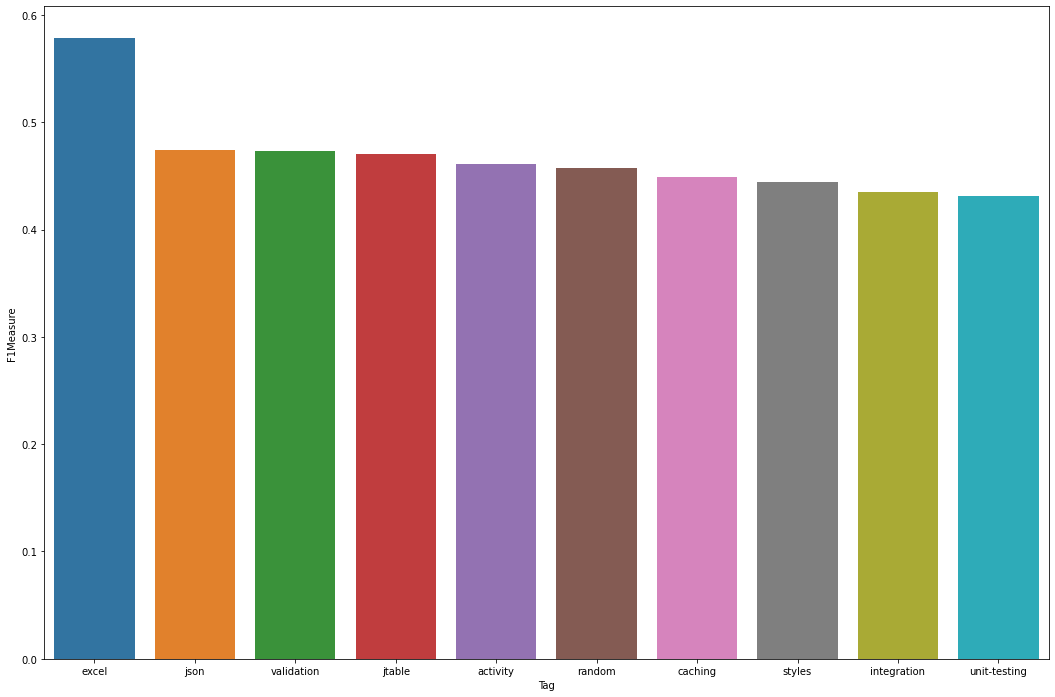

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=plot_df, ax=ax)
fig.show()

<ipython-input-29-50c39e5a4985>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


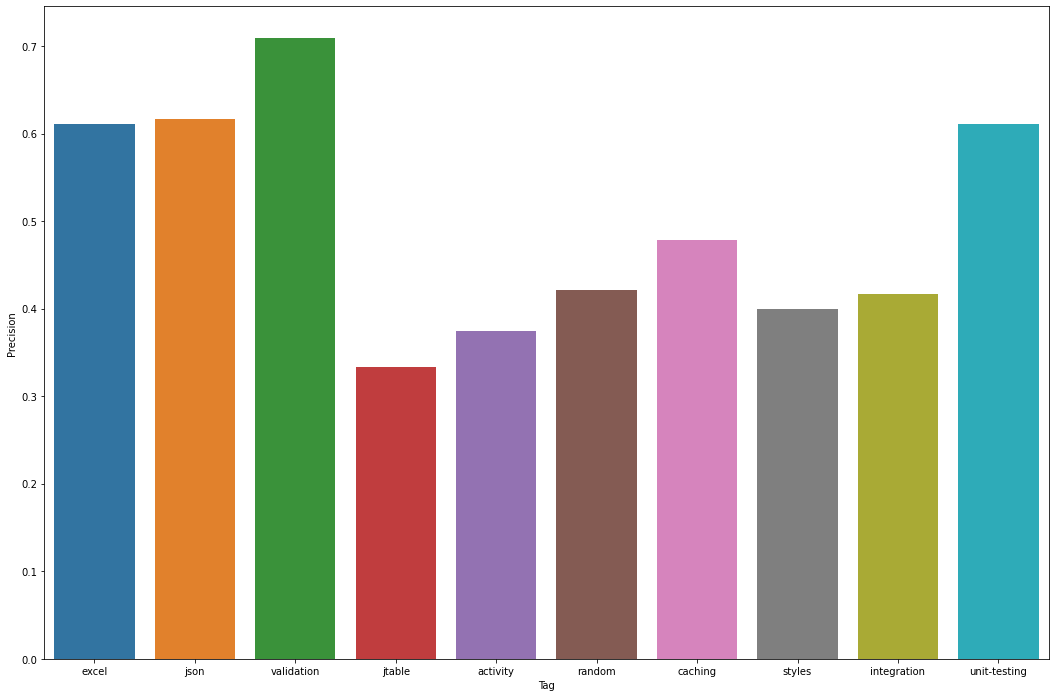

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Precision", data=plot_df, ax=ax)
fig.show()

<ipython-input-30-61652f8e098d>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


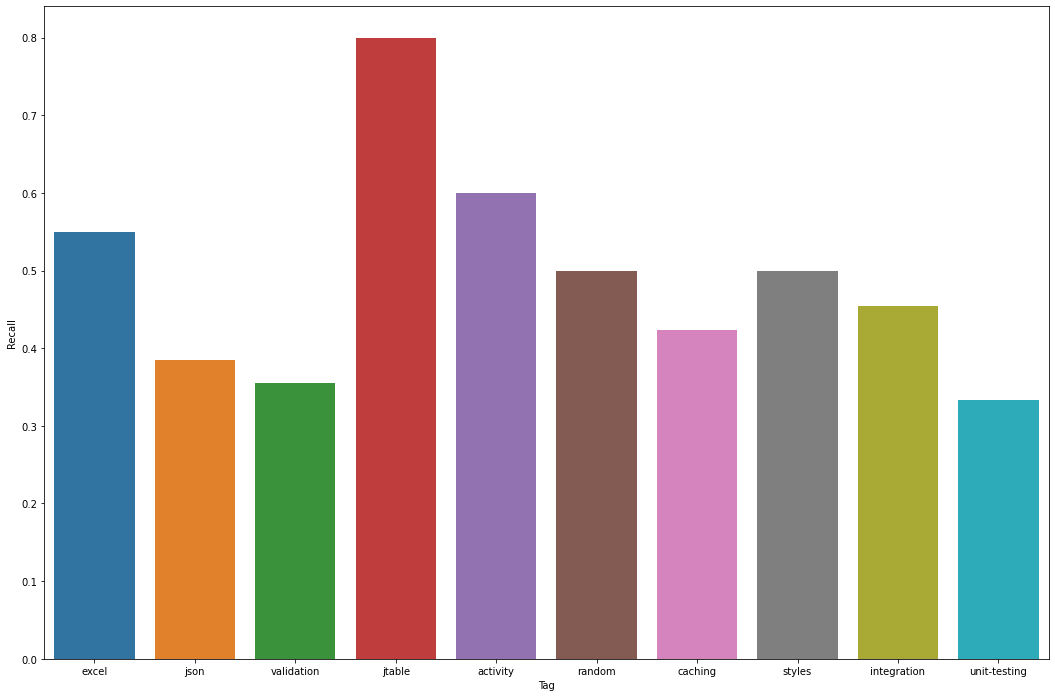

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Recall", data=plot_df, ax=ax)
fig.show()

<ipython-input-1-5f396c8922ba>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


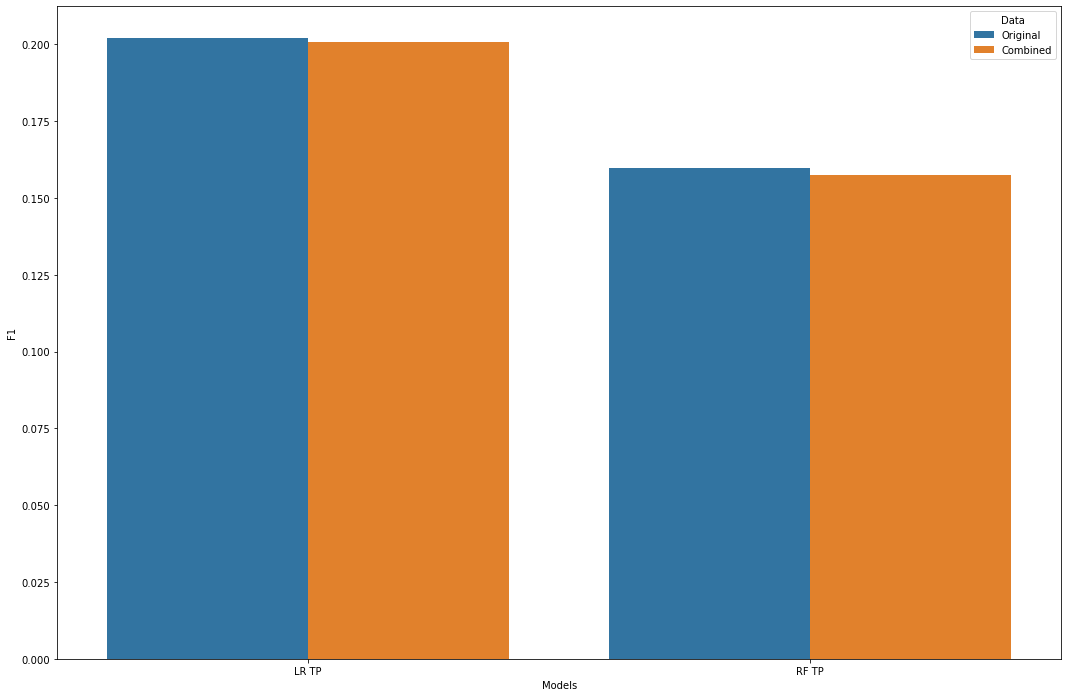

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# F1 Weighted Results 
lr_trad_train = 0.20224616277784171
lr_trad_comb = 0.20072543145361293
rf_trad_train = 0.1597831475302337
rf_trad_comb = 0.15764380098225084
this_dict = {'Models': ["LR TP", "LR TP", "RF TP", "RF TP"], 
             "F1": [lr_trad_train, lr_trad_comb, rf_trad_train, rf_trad_comb],
             "Data": ["Original", "Combined", "Original", "Combined"]}

seaborn_df = pd.DataFrame.from_dict(this_dict)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Models", y="F1", hue="Data", data=seaborn_df, ax =ax)
fig.show()

In [9]:
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
labels_and_predictions = top_df.select(["tag_idx", "prediction"])

# Instantiate metrics object
metrics = MulticlassMetrics(labels_and_predictions.rdd)

# Overall statistics
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

# Statistics by class
labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
for label in sorted(labels):
    try:
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    except: 
        print("Class %s not in this set!" % (label))

Summary Stats
Precision = 0.312
Recall = 0.09798994974874371
F1 Score = 0.14913957934990438
Weighted recall = 0.17358376249621318
Weighted precision = 0.2876639788528822
Weighted F(1) Score = 0.20072543145361293
Weighted F(0.5) Score = 0.2395734009187582
Weighted false positive rate = 0.0034651431087330824
Class 0.0 precision = 0.3888888888888889
Class 0.0 recall = 0.16488222698072805
Class 0.0 F1 Measure = 0.23157894736842108
Class 1.0 precision = 0.312
Class 1.0 recall = 0.09798994974874371
Class 1.0 F1 Measure = 0.14913957934990438
Class 2.0 precision = 0.4696969696969697
Class 2.0 recall = 0.2551440329218107
Class 2.0 F1 Measure = 0.33066666666666666
Class 3.0 precision = 0.3115942028985507
Class 3.0 recall = 0.17916666666666667
Class 3.0 F1 Measure = 0.22751322751322753
Class 4.0 precision = 0.24752475247524752
Class 4.0 recall = 0.13020833333333334
Class 4.0 F1 Measure = 0.17064846416382254
Class 5.0 precision = 0.2676056338028169
Class 5.0 recall = 0.10555555555555556
Class 5.0 

Class 310.0 precision = 0.6
Class 310.0 recall = 0.08108108108108109
Class 310.0 F1 Measure = 0.14285714285714288
Class 311.0 precision = 0.0
Class 311.0 recall = 0.0
Class 311.0 F1 Measure = 0.0
Class 312.0 precision = 0.15384615384615385
Class 312.0 recall = 0.047619047619047616
Class 312.0 F1 Measure = 0.07272727272727272
Class 313.0 precision = 0.18181818181818182
Class 313.0 recall = 0.06666666666666667
Class 313.0 F1 Measure = 0.0975609756097561
Class 314.0 not in this set!
Class 315.0 precision = 0.0
Class 315.0 recall = 0.0
Class 315.0 F1 Measure = 0.0
Class 316.0 precision = 0.10526315789473684
Class 316.0 recall = 0.4
Class 316.0 F1 Measure = 0.16666666666666666
Class 317.0 precision = 0.5
Class 317.0 recall = 0.14634146341463414
Class 317.0 F1 Measure = 0.22641509433962262
Class 318.0 precision = 0.08333333333333333
Class 318.0 recall = 0.05555555555555555
Class 318.0 F1 Measure = 0.06666666666666667
Class 319.0 precision = 0.3333333333333333
Class 319.0 recall = 0.222222222

Class 469.0 not in this set!
Class 470.0 precision = 0.0
Class 470.0 recall = 0.0
Class 470.0 F1 Measure = 0.0
Class 471.0 precision = 0.0
Class 471.0 recall = 0.0
Class 471.0 F1 Measure = 0.0
Class 472.0 precision = 0.2222222222222222
Class 472.0 recall = 0.3333333333333333
Class 472.0 F1 Measure = 0.26666666666666666
Class 473.0 not in this set!
Class 474.0 not in this set!
Class 475.0 not in this set!
Class 476.0 precision = 0.0
Class 476.0 recall = 0.0
Class 476.0 F1 Measure = 0.0
Class 477.0 precision = 0.4444444444444444
Class 477.0 recall = 0.36363636363636365
Class 477.0 F1 Measure = 0.39999999999999997
Class 478.0 precision = 0.1
Class 478.0 recall = 0.3333333333333333
Class 478.0 F1 Measure = 0.15384615384615383
Class 479.0 not in this set!
Class 480.0 not in this set!
Class 481.0 precision = 0.0
Class 481.0 recall = 0.0
Class 481.0 F1 Measure = 0.0
Class 482.0 not in this set!
Class 483.0 precision = 0.0
Class 483.0 recall = 0.0
Class 483.0 F1 Measure = 0.0
Class 484.0 preci

In [10]:
top_df = top_df.withColumn("correct", top_df.prediction==top_df.tag_idx)
tag_corrects = top_df.groupby('tag').agg(F.sum(F.col("correct").cast("long"))).withColumnRenamed("sum(CAST(correct AS BIGINT))", "correct_sum")
tag_counts = top_df.groupBy("tag").count()
correct_tags = tag_corrects.join(tag_counts, on='tag')
correct_tags.show()

+-------------------+-----------+-----+
|                tag|correct_sum|count|
+-------------------+-----------+-----+
|             iframe|          1|   17|
|              input|          0|    8|
|             import|          2|    7|
|            include|          0|    6|
|            routing|          5|   19|
|     android-widget|          0|    6|
|             charts|          0|   11|
|           doctrine|          0|   11|
|           gridview|          3|   27|
|           keyboard|          1|   18|
|                map|          6|   12|
|                 qt|          0|   19|
|                jar|          2|   13|
|network-programming|          0|   12|
|              boost|          0|   15|
|                rss|          1|    8|
|         phpmyadmin|          0|    7|
|            session|          5|   22|
|     drop-down-menu|          3|   22|
|   image-processing|          0|   15|
+-------------------+-----------+-----+
only showing top 20 rows



In [13]:
from pyspark.sql.functions import col

correct_tags.sort(col('correct_sum').desc()).show()

+---------------+-----------+-----+
|            tag|correct_sum|count|
+---------------+-----------+-----+
|           html|         77|  198|
|           ajax|         62|  132|
|           json|         45|   73|
|            css|         43|  138|
|            ios|         39|  125|
|          query|         29|   61|
|          image|         28|   45|
|         string|         27|   53|
|          forms|         26|   59|
|ruby-on-rails-3|         25|   51|
|          xcode|         25|  101|
|           linq|         23|   53|
|         events|         22|   44|
|     validation|         22|   31|
|       database|         19|   71|
|      variables|         18|   30|
|           list|         17|   32|
|         arrays|         16|   50|
|            url|         16|   34|
| multithreading|         16|   38|
+---------------+-----------+-----+
only showing top 20 rows



In [14]:
correct_tags = correct_tags.withColumn("accuracy", F.col("correct_sum") / F.col("count"))
correct_tags.orderBy("accuracy", ascending=False).show()

+-----------------+-----------+-----+-------------------+
|              tag|correct_sum|count|           accuracy|
+-----------------+-----------+-----+-------------------+
|       validation|         22|   31| 0.7096774193548387|
|            image|         28|   45| 0.6222222222222222|
|             json|         45|   73| 0.6164383561643836|
|            excel|         11|   18| 0.6111111111111112|
|     unit-testing|         11|   18| 0.6111111111111112|
|        ms-access|          3|    5|                0.6|
|        variables|         18|   30|                0.6|
|stored-procedures|         13|   23| 0.5652173913043478|
|             list|         17|   32|            0.53125|
|      inheritance|          9|   17| 0.5294117647058824|
|           string|         27|   53| 0.5094339622641509|
|            limit|          1|    2|                0.5|
|              map|          6|   12|                0.5|
|           insert|          6|   12|                0.5|
|           ev

In [15]:
correct_tags.write.parquet("correct_tags_comb")

In [16]:
top_10_accuracy = correct_tags.orderBy("accuracy", ascending=False).limit(10).toPandas()
top_10_count = correct_tags.orderBy("count", ascending=False).limit(10).toPandas()
top_10_correct = correct_tags.orderBy("correct_sum", ascending=False).limit(10).toPandas()

<ipython-input-17-c997699e9815>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


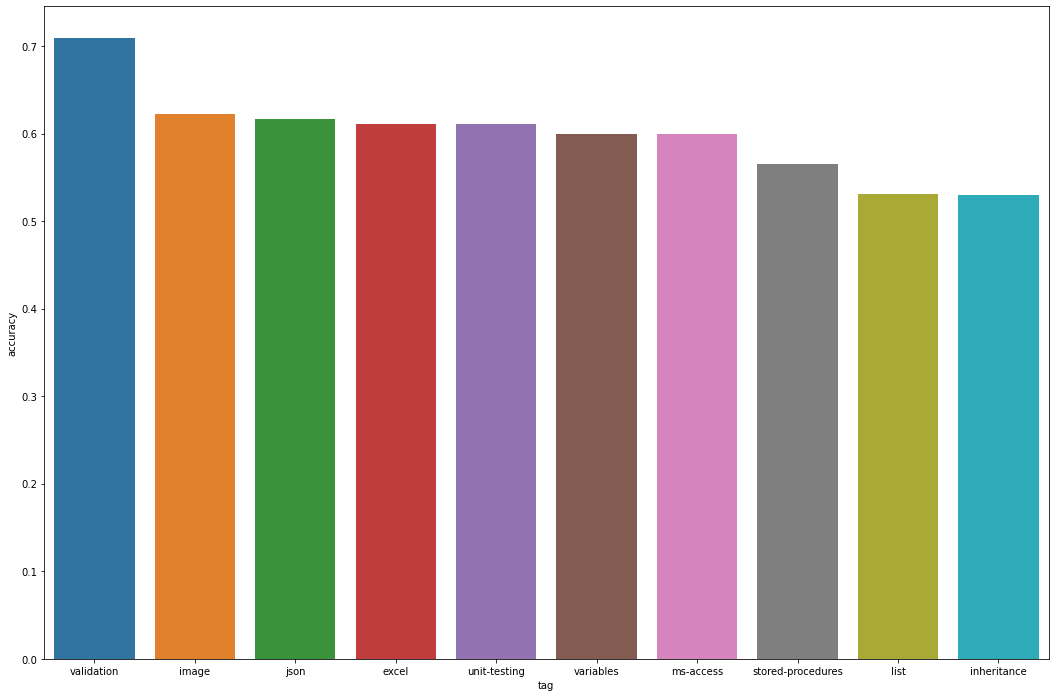

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="tag", y="accuracy", data=top_10_accuracy, ax =ax)
fig.show()

<ipython-input-18-98240cbc50d0>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


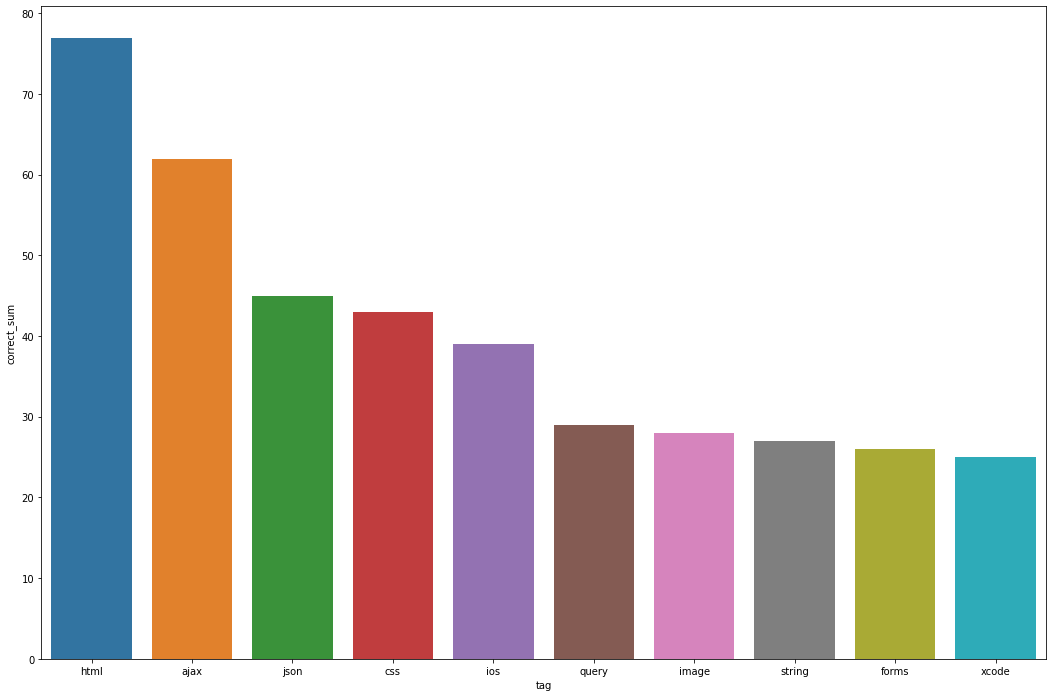

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="tag", y="correct_sum", data=top_10_correct, ax =ax)
fig.show()

<ipython-input-19-ae7848d465e2>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


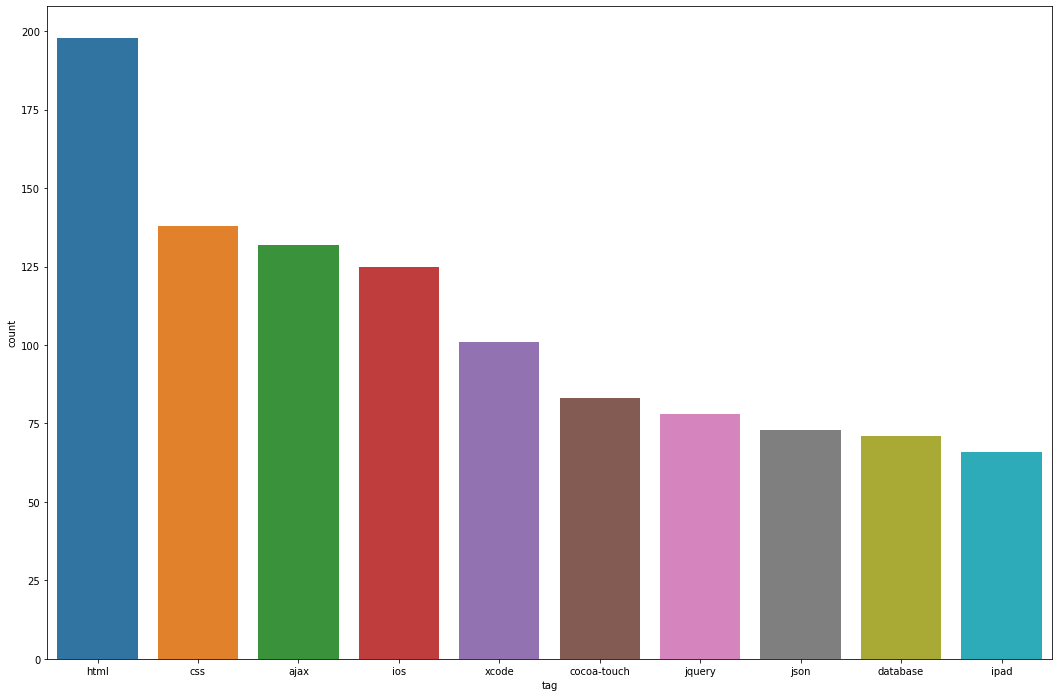

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="tag", y="count", data=top_10_count, ax =ax)
fig.show()

In [21]:
bottom_10_accuracy = correct_tags.orderBy("accuracy").limit(10).toPandas()
bottom_10_count = correct_tags.orderBy("count").limit(10).toPandas()
bottom_10_correct = correct_tags.orderBy("correct_sum").limit(10).toPandas()

In [24]:
display(bottom_10_accuracy)

,tag,correct_sum,count,accuracy
0,phpmyadmin,0,7,0.0
1,boost,0,15,0.0
2,network-programming,0,12,0.0
3,doctrine,0,11,0.0
4,input,0,8,0.0
5,charts,0,11,0.0
6,android-widget,0,6,0.0
7,include,0,6,0.0
8,qt,0,19,0.0
9,image-processing,0,15,0.0


In [26]:
display(bottom_10_correct)

,tag,correct_sum,count,accuracy
0,phpmyadmin,0,7,0.0
1,input,0,8,0.0
2,boost,0,15,0.0
3,doctrine,0,11,0.0
4,network-programming,0,12,0.0
5,charts,0,11,0.0
6,android-widget,0,6,0.0
7,include,0,6,0.0
8,qt,0,19,0.0
9,image-processing,0,15,0.0


In [25]:
display(bottom_10_count)

,tag,correct_sum,count,accuracy
0,scope,0,2,0.00
1,limit,1,2,0.50
2,jsf-2,0,3,0.00
3,doctrine2,1,4,0.25
4,nginx,0,5,0.00
5,styles,2,5,0.40
6,mfc,0,5,0.00
7,joomla,0,5,0.00
8,svg,0,5,0.00
9,bitmap,0,5,0.00
